In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import cm
import datetime
import pickle
sys.path.append('recurrent-kernel-stability-main')


from Reservoir import Reservoir

%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# the default resolution to use when generating loss landscape visualizations.
# for final products, this should be much larger! e.g. 4096.
default_resolution = 50
# default_resolution = 4096
interactive_gui = True
# figure size, and dpi to use when saving figures.
# (this is mostly overwritten for specific use cases, e.g. saving video. check
# the load_and_generate(...) function)
dpi = 100
figsize = (8,8)
#init
image_history = []
res_scale_bounds=[0, 3]
input_scale_bounds=[0, 2]

In [78]:
## tool for computing fractal dimension
!pip install git+https://github.com/PMEAL/porespy.git
import porespy as ps

  Cloning https://github.com/PMEAL/porespy.git to /tmp/pip-req-build-ipy8lhxl
  Running command git clone --filter=blob:none --quiet https://github.com/PMEAL/porespy.git /tmp/pip-req-build-ipy8lhxl
  Resolved https://github.com/PMEAL/porespy.git to commit d83eef89dc3b680b08d77ea3f8a95384f8934b91
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [79]:
if interactive_gui:
  ## interactive plotting
  !pip install ipympl
  from google.colab import output
  output.enable_custom_widget_manager()
  %matplotlib ipympl
else:
  matplotlib.use('Agg')

In [81]:
def stability_test(function="arcsin",  res_size = 100, input_size= 100, input_len = 200, resolution=20, res_scale_bounds=[0, 3], input_scale_bounds=[0, 2]):
  input_data = torch.randn(input_len, input_size).to(device)
  for i in range(input_len):  # normalize input at each timestep
      input_data[i, :] = input_data[i, :] / torch.norm(input_data[i, :])

  res_scale_list = np.linspace(res_scale_bounds[0], res_scale_bounds[1], num=resolution)
  input_scale_list = np.linspace(input_scale_bounds[0], input_scale_bounds[1], num=resolution)
  final_metric = torch.zeros(resolution, resolution)
  W_in = torch.randn(res_size, input_size).to(device)
  W_res = torch.randn(res_size, res_size).to(device)
  for (i_res, res_scale) in enumerate(res_scale_list):
      for (i_in, input_scale) in enumerate(input_scale_list):
          RC = Reservoir(f="erf", input_size=input_size, res_size=res_size,
                         W_res=W_res, W_in=W_in,
                         res_scale=res_scale, input_scale=input_scale)
          rc_metric = RC.stability_test(input_data)
          final_metric[i_res, i_in] = rc_metric[-1]
  return final_metric

In [82]:
metric_erf = stability_test(resolution=default_resolution, res_scale_bounds=res_scale_bounds, input_scale_bounds=input_scale_bounds)

KeyboardInterrupt: 

In [66]:
metric_erf.T<1e-6

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

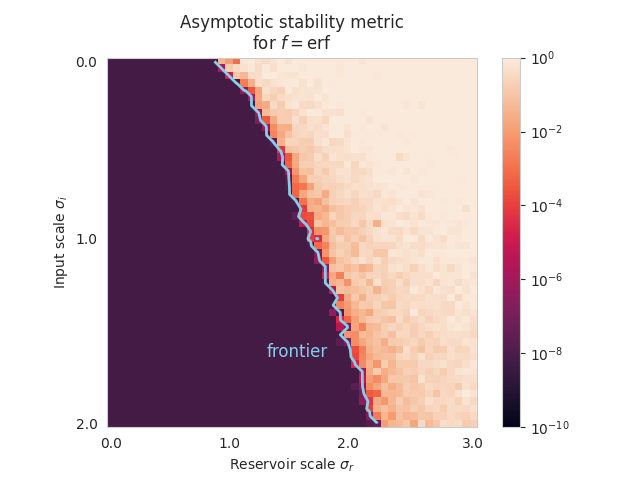

In [71]:
import matplotlib

plt.figure()
seaborn.set_style("whitegrid")
img = metric_erf.T
img[img<1e-6]= 1e-6
plt.imshow(img, norm=matplotlib.colors.LogNorm(vmin= 1e-10, vmax = 1))#

ax = plt.gca()
plt.grid(False)
plt.clim(1e-10, 1)
plt.colorbar()

ylab = np.linspace(input_scale_bounds[0], input_scale_bounds[1], num=int(input_scale_bounds[1]+1))
xlab = np.linspace(res_scale_bounds[0], res_scale_bounds[1], num=int(res_scale_bounds[1]+1))
indXx = np.linspace(0, default_resolution-1, num=xlab.shape[0]).astype(int)
indXy = np.linspace(0, default_resolution-1, num=ylab.shape[0]).astype(int)

color = "skyblue"
plt.contour(metric_erf.T, levels=[1e-3], colors=color, linewidths=[2])
# plt.annotate('frontier', xy=(70, 80), color=color)
plt.annotate('frontier', xy=(21, 40), color=color, fontsize=12)

ax.set_xticks(indXx)
ax.set_xticklabels(xlab)
ax.set_yticks(indXy)
ax.set_yticklabels(ylab)
ax.set_xlabel('Reservoir scale $\sigma_r$')
ax.set_ylabel('Input scale $\sigma_i$')
ax.set_title('Asymptotic stability metric\nfor $f=$erf')

# plt.savefig("220125relu.svg")
plt.show()


In [97]:
metric_erf.T

tensor([[2.0000e-06, 2.0000e-06, 2.0000e-06,  ..., 1.5670e+00, 1.6501e+00,
         1.4939e+00],
        [2.0000e-06, 2.0000e-06, 2.0000e-06,  ..., 1.6380e+00, 1.4895e+00,
         1.4998e+00],
        [2.0000e-06, 2.0000e-06, 2.0000e-06,  ..., 1.7332e+00, 1.5904e+00,
         1.3240e+00],
        ...,
        [2.0000e-06, 2.0000e-06, 2.0000e-06,  ..., 5.1511e-01, 4.6368e-01,
         6.8043e-01],
        [2.0000e-06, 2.0000e-06, 2.0000e-06,  ..., 3.7054e-01, 3.5951e-01,
         5.0349e-01],
        [2.0000e-06, 2.0000e-06, 2.0000e-06,  ..., 5.5243e-01, 2.6482e-01,
         3.0739e-01]])

In [35]:
#we're not using this
'''
def extract_edges(X):
  """
  define edges as sign changes in the scalar representing convergence or
  divergence rate -- on one side of the edge training converges,
  while on the other side of the edge training diverges
  """

  Y = np.stack((X[1:,1:], X[:-1,1:], X[1:,:-1], X[:-1,:-1]), axis=-1)
  Z = np.sign(np.max(Y, axis=-1)*np.min(Y, axis=-1))
  return Z<0

def estimate_fractal_dimension(hist_video, show_plot=True):
  edges = [extract_edges(U[0]) for U in hist_video]
  box_counts = [ps.metrics.boxcount(U) for U in edges]
  all_images = np.concatenate([bc.slope for bc in box_counts])

  if show_plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel('box edge length')
    ax1.set_ylabel('number of boxes spanning phases')
    ax2.set_xlabel('box edge length')
    ax2.set_ylabel('image')
    ax2.set_xscale('log')

    for bc in box_counts:
      ax1.plot(bc.size, bc.count,'-o')
      ax2.plot(bc.size, bc.slope,'-o');

  mfd = np.median(all_images)
  print(f'median fractal dimension estimate {mfd}')

  return mfd
  '''

In [83]:
def cdf_img(x, x_ref, buffer=0.25):
  """
  rescale x, relative to x_ref (x_ref is often the same as x), to achieve a uniform
  distribution over values with positive and negative intensities, but also to
  preserve the sign of x. This makes for a visualization that shows more
  structure.
  """

  u = np.sort(x_ref.ravel())


  num_neg = np.sum(u<0)
  num_nonneg = u.shape[0] - num_neg
  v = np.concatenate((np.linspace(-1,-buffer,num_neg), np.linspace(buffer,1,num_nonneg)), axis=0)


  y = np.interp(x, u, v)
  return -y

In [84]:
def tickslabels(mnmx):
  return mnmx, mnmx


In [94]:
cids = []
click_event = [None]

def onclick(event):
  click_event[0] = (event.xdata, event.ydata)

def onrelease(event, fig, im, rect, mnmx, img, recalculate_image=True):
  if click_event[0] is None:
    return

  e0 = [click_event[0][0], event.xdata]
  e1 = [click_event[0][1], event.ydata]

  for v in e0+e1:
    if v is None:
      return

  newmnmx = [np.min(e1), np.max(e1), np.min(e0), np.max(e0)]

  min_w = (mnmx[1] - mnmx[0])/20
  if newmnmx[1] - newmnmx[0] < min_w:
    c = (newmnmx[1] + newmnmx[0])/2.
    newmnmx[0] = c - min_w/2
    newmnmx[1] = c + min_w/2
  min_w = (mnmx[3] - mnmx[2])/20
  if newmnmx[1] - newmnmx[0] < min_w:
    c = (newmnmx[3] + newmnmx[2])/2.
    newmnmx[2] = c - min_w/2
    newmnmx[3] = c + min_w/2

  for v in newmnmx:
    if v is None:
      return
  plot_img(img, mnmx, newmnmx, fig=fig, im=im, rect=rect)
  plt.draw()

  if recalculate_image:
    click_event[0] = None
    mnmx = newmnmx
    img = stability_test()
    plot_img(img, mnmx, None, fig=fig, im=im, rect=rect)

def plot_img(image, mnmx, newmnmx=None, fig=None, im=None, rect=None,
             handler=True, savename=None,
             reference_scale=None,
             cmap='Spectral',
             title=""
             ):
  mn1, mx1, mn2, mx2 = mnmx

  if reference_scale is None:
    reference_scale = image

  image = cdf_img(image, reference_scale)

  ax1 = None
  if fig is None:
    fig, (ax1) = plt.subplots(figsize=figsize, dpi=dpi)
    #im = ax1.imshow(img, norm=matplotlib.colors.LogNorm(vmin= 1e-10, vmax = 1))
    '''
    im = ax1.imshow(image,
                    extent=[mn1, mx1, mn2, mx2],
                    origin='upper',
                    vmin=1e-6, vmax=1,
                    cmap=cmap,
                    aspect='auto',
                    interpolation='nearest'
                    )
    '''
    plt.colorbar(im, ax=ax1)

    title = f'Stability dependence on input scale and reservoir scale'
    if not title == "":
      plt.title(title)
    ax1.set_ylabel('Input scale')
    ax1.set_xlabel('Reservoir scale')


    rect = patches.Rectangle((mn2, mn1), mx2-mn2, mx1-mn1, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)

  im.set_extent([mn1, mx1, mn2, mx2])
  im.set_data(image)

  # Set the new tick positions on the x-axis
  aaxx = plt.gca()
  aaxx.set_xticks(*tickslabels([mn1, mx1]))
  aaxx.set_yticks(*tickslabels([mn2, mx2]), rotation=90)

  labels = aaxx.get_xticklabels()
  labels[0].set_horizontalalignment('left')
  labels[1].set_horizontalalignment('right')
  labels = aaxx.get_yticklabels()
  labels[0].set_verticalalignment('bottom')
  labels[1].set_verticalalignment('top')

  if handler and (newmnmx is None):
    image_history.append((image, mnmx))

  if newmnmx:
    mn1, mx1, mn2, mx2 = newmnmx
  rect.set_xy((mn2, mn1))
  rect.set_width(mx2-mn2)
  rect.set_height(mx1-mn1)

  if handler:
    while len(cids) > 0:
      fig.canvas.mpl_disconnect(cids.pop())

    def onrelease_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img)
    def onmotion_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img, recalculate_image=False)

    cids.append(fig.canvas.mpl_connect('button_press_event', onclick))
    cids.append(fig.canvas.mpl_connect('button_release_event', onrelease_partial))
    # cids.append(fig.canvas.mpl_connect('motion_notify_event', onmotion_partial))

  plt.tight_layout()

  plt.draw()

  if savename:
    plt.savefig(savename)

  return fig, ax1, im


In [99]:
img.T

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0306e+00, 1.2405e+00,
         1.1082e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4111e-01, 1.2388e+00,
         1.8368e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4703e+00, 1.3325e+00,
         1.4036e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.4718e-14, 4.6255e-14,
         1.8778e-09],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6019e-14, 4.8807e-14,
         1.2203e-12],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.1319e-14, 3.0925e-14,
         2.5344e-12]])

In [ ]:
mnmx = [0, 2, 0, 3]
img = stability_test(input_scale_bounds=mnmx[:2],res_scale_bounds=mnmx[2:], resolution = default_resolution)


(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Stability dependence on input scale and reservoir scale'}, xlabel='Reservoir scale', ylabel='Input scale'>,
 <matplotlib.image.AxesImage at 0x7e87b1994370>)

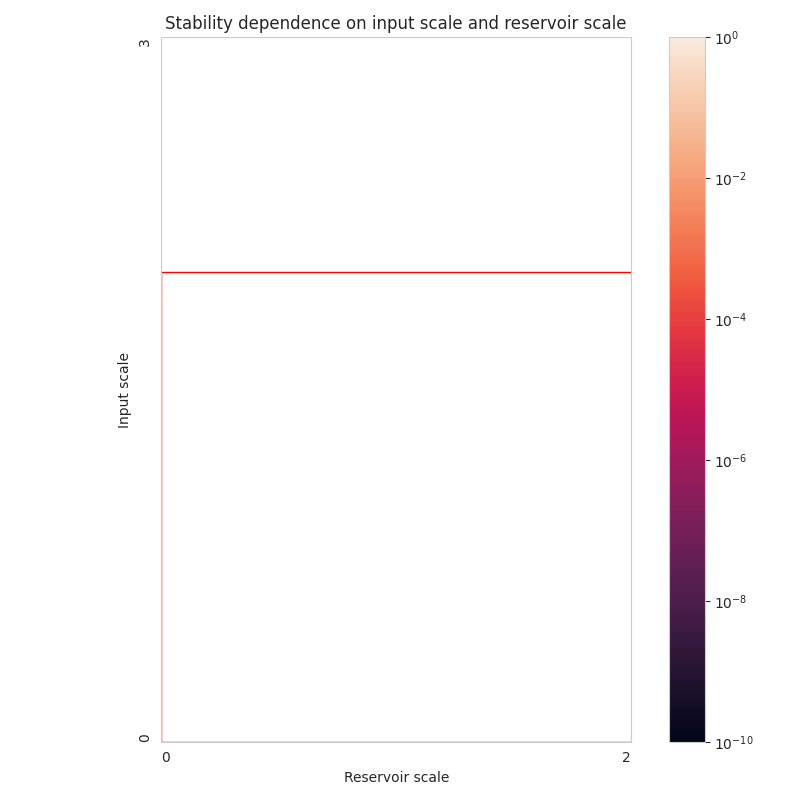

In [95]:
plot_img(img.T, mnmx, None)

In [87]:
*def zoom_out_sequence(hist_final, growth_factor=2., max_scale=6):
  """
  generate a sequence of (image, bounds) zooming out from the (image, bounds) in hist_final
  """

  image, mnmx = hist_final

  cT = np.array([(mnmx[0] + mnmx[1])/2., (mnmx[2] + mnmx[3])/2.])
  wT = np.array([mnmx[1] - mnmx[0], mnmx[3] - mnmx[2]])

  hist = [(image, mnmx)]
  w_scale = 1.
  while np.min(wT * w_scale) < max_scale:
    w_scale *= 2
    mnmx = [
        cT[0] - w_scale * wT[0]/2.,
        cT[0] + w_scale * wT[0]/2.,
        cT[1] - w_scale * wT[1]/2.,
        cT[1] + w_scale * wT[1]/2.,
    ]
    hist.insert(0, (np.zeros((2,2)), mnmx))

  return hist

def increase_resolution(history, target_res):
  """
  Increase the resolution of images of a fractal landscape that we've already
  generated.

  Find the first entry in history with resolution below target_res, and increase
  its resolution. If all images are already at least the target resolution,
  return False.
  """

  new_h = []
  for ii in range(len(history)):
    h = history[ii]
    image, mnmx = h
    if image.shape[0] < target_res:
      current_time = datetime.datetime.now()
      print( f"increasing resolution of {ii} / {len(history)} at {current_time}, current resolution is {image.shape}")
      image = stability_test(input_scale_bounds=mnmx[:2], res_scale_bounds=mnmx[2:], resolution=target_res)
      history[ii] = (image, mnmx)
      return True
  return False


In [74]:
def interpolate_history(hist1, hist2, alpha):
  """
  get the mnmx (hyperparameter bounding box) value for a fraction alpha between
  two images
  """

  _, mnmx1 = hist1
  _, mnmx2 = hist2

  if alpha == 0:
    # avoid NaNs on very last frame
    return mnmx1

  w1 = np.array([mnmx1[1] - mnmx1[0], mnmx1[3] - mnmx1[2]])
  w2 = np.array([mnmx2[1] - mnmx2[0], mnmx2[3] - mnmx2[2]])
  c1 = np.array([(mnmx1[0] + mnmx1[1])/2, (mnmx1[2] + mnmx1[3])/2])
  c2 = np.array([(mnmx2[0] + mnmx2[1])/2, (mnmx2[2] + mnmx2[3])/2])

  gamma = np.exp((1-alpha)*0 + alpha*np.log(w2/w1))

  # ct = cstar + (c1 - cstar)*gamma
  # c1 = cstar + (c1 - cstar)*1
  # c2 = cstar + (c1 - cstar)*w2/w1
  cstar = (c2 - c1*w2/w1) / (1 - w2 / w1)

  ct = cstar + (c1 - cstar)*gamma
  hwt = gamma*w1

  return [ct[0] - hwt[0]/2, ct[0] + hwt[0]/2, ct[1] - hwt[1]/2, ct[1] + hwt[1]/2]


def em(extent_rev):
  return [extent_rev[2], extent_rev[3], extent_rev[0], extent_rev[1]]

def make_animator(history, timesteps_per_transition=60, reference_scale=None, cmap='Spectral'):

  fig, ax, im1 = plot_img(history[0][0], history[0][1], newmnmx=None,
                          handler=False, reference_scale=reference_scale, cmap=cmap)

  im2 = ax.imshow(
      np.zeros_like(history[1][0]), extent=em(history[1][1]), origin='lower',
      vmin = -1, vmax = 1,
      cmap=cmap,
      aspect='auto',
      interpolation='nearest'
      )

  im3 = ax.imshow(
      np.zeros_like(history[1][0]), extent=em(history[1][1]), origin='lower',
      vmin = -1, vmax = 1,
      cmap=cmap,
      aspect='auto',
      interpolation='nearest'
      )

  def animate(n):
    hist_index = n // timesteps_per_transition
    alpha = (n % timesteps_per_transition) / timesteps_per_transition

    hist1 = history[hist_index]
    if hist_index >= len(history)-1:
      hist2 = hist1 # very last frame
    else:
      hist2 = history[hist_index+1]
    if hist_index >= len(history)-2:
      hist3 = hist2 # very last frame
    else:
      hist3 = history[hist_index+2]

    lims = interpolate_history(hist1, hist2, alpha)

    # interpolation scheme for image restretch / colormap
    alpha_area = np.sin(alpha*np.pi/2)**2

    print(f'frame {n} / {timesteps_per_transition*len(history)}, zoom step {hist_index} / {len(history)}', end='\r', flush=True)

    img_1 = (1-alpha_area)*cdf_img(hist1[0], hist1[0]) + alpha_area*cdf_img(hist1[0], hist2[0])
    img_2 = (1-alpha_area)*cdf_img(hist2[0], hist1[0]) + alpha_area*cdf_img(hist2[0], hist2[0])
    img_3 = (1-alpha_area)*cdf_img(hist3[0], hist1[0]) + alpha_area*cdf_img(hist3[0], hist2[0])

    im1.set_data(img_1)
    im1.set_extent(em(hist1[1]))
    im2.set_data(img_2)
    im2.set_extent(em(hist2[1]))
    im3.set_data(img_3)
    im3.set_extent(em(hist3[1]))
    im3.set_alpha(alpha)

    ax.set_ylim(lims[0], lims[1])
    ax.set_xlim(lims[2], lims[3])

    # Set the new tick positions
    ax.set_xticks(*tickslabels([lims[2], lims[3]]))
    ax.set_yticks(*tickslabels([lims[0], lims[1]]), rotation=90)

    labels = ax.get_xticklabels()
    labels[0].set_horizontalalignment('left')
    labels[1].set_horizontalalignment('right')
    labels = ax.get_yticklabels()
    labels[0].set_verticalalignment('bottom')
    labels[1].set_verticalalignment('top')

    return fig,

  anim = animation.FuncAnimation(fig,animate,frames=timesteps_per_transition*(len(history)-1)+1, repeat=False)
  return anim

In [ ]:
hist_video = zoom_out_sequence(image_history[-1], growth_factor=2.)

In [75]:
def canonical_name():
  return 'test'

In [ ]:
# each call to increase_resolution increases the resolution of one image and
# returns True, or returns False if all images are at or exceed the target resolution
while increase_resolution(hist_video, 2048):
  with open(f'/content/drive/MyDrive/fractal/{canonical_name()}.pickle', 'wb') as handle:
      pickle.dump(hist_video, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ts = 30
anim = make_animator(hist_video, timesteps_per_transition=ts*2)
anim.save(f'/content/drive/MyDrive/fractal/{canonical_name()}.mp4',fps=ts, dpi=dpi)
plt.close('all')

In [ ]:
def load_and_generate(canonical=None, max_frame=999999):
  global dpi
  global figsize

  dpi = 1000
  figsize = (5.2,4.5)

  assert not interactive_gui, "Set interactive_gui to False in the first cell, and restart the colab kernel"

  if canonical is None:
    canonical = canonical_name()

  print(f'generating images and movie for {canonical}')

  with open(f'/content/drive/MyDrive/fractal/{canonical}.pickle', 'rb') as handle:
    hist_video = pickle.load(handle)

  hist_video = hist_video[:max_frame]

  # make sure we are at full resolution
  # each call to increase_resolution increases the resolution of one image and returns True, or returns False if all images are at or exceed the targer resolution
  while increase_resolution(hist_video, 4096):
    with open(f'/content/drive/MyDrive/fractal/{canonical}.pickle', 'wb') as handle:
        pickle.dump(hist_video, handle, protocol=pickle.HIGHEST_PROTOCOL)

  for ii, impair in enumerate(hist_video):
    img, mnmx = impair
    fname = f'/content/drive/MyDrive/fractal/{canonical}_step-{ii}.pdf'
    plot_img(img, mnmx, handler=False, savename=fname, title="")
    plt.close('all')

  estimate_fractal_dimension(hist_video)
  plt.close('all')

  # dpi of 1500 might seem excessive, but we need a very high resolution,
  # otherwise we get ugly transcoding errors when we upload to vimeo or youtube
  dpi = 1500
  figsize = (5.5,5.5)
  ts = 30
  anim = make_animator(hist_video, timesteps_per_transition=int(ts*1.5))
  fname = f'{canonical}.mp4'
  writer=animation.FFMpegWriter(bitrate=200000, codec='hevc', fps=ts)
  anim.save(fname, dpi=dpi, writer=writer)
  shutil.copyfile(fname, f'/content/drive/MyDrive/fractal/{fname}')
  plt.close('all')